# Dense network demonstrations

The ``torch_tools.DenseNetwork`` model can be used for classification or regression.

First, Let's use it for a classification problem.

* Some data:
    * For the classification and regression examples we will use some datasets available from scikit-learn.
    * We will also need to load the data using a ``Dataset`` and ``DataLoader``.
* A model:
    * We will instantiate the model shortly.
* A loss function.
* A optimiser to fit the model with.

## Classification example


Scikit learn has a bunch of available datasets that we can select an example from to use as a guinea pig. We will use the breast cancer classification dataset. These data include physical measurements from various tumours, and their status as malignant or normal.

Let's grab the data from scikit-learn:

In [10]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer(as_frame=True).frame

valid_split = data.groupby("target").sample(frac=0.2, random_state=123)

train_split = data.loc[~data.index.isin(valid_split.index)]

print(train_split.shape)
print(valid_split.shape)

(456, 31)
(113, 31)


Now we have downloaded the breast cancer dataset from scikit-learn, and split the data into a training and validation set. Conventially, one should split the data into a training, validation and testing set, but since this is only a simple example to illustrate use of the model, we skip this formality.

As a matter of convenience, let's grab a list of the keys for accessing the data and targets separately.

In [11]:
data_keys = list(filter(lambda x: x != "target", data.keys()))
target_keys = ["target"]

Now, let's create a training and validation dataset.

In [12]:
import torch
from torchvision.transforms import Compose

from torch_tools import DataSet

train_set = DataSet(
    inputs=tuple(train_split[data_keys].to_numpy()),
    targets=tuple(train_split[target_keys].to_numpy()),
    target_tfms=Compose([lambda x: torch.eye(2)[x].squeeze()]),
)

valid_set = DataSet(
    inputs=tuple(valid_split[data_keys].to_numpy()),
    targets=tuple(valid_split[target_keys].to_numpy()),
    target_tfms=Compose([lambda x: torch.eye(2)[x].squeeze()]),
)

# Let's grab an input and target from the validation set and see what we get.
x_item, y_item = valid_set[0]

print(x_item.shape)
print(y_item.shape)

(30,)
torch.Size([2])


PyTorch Datasets generally return single input-target pairs, but when training neural networks we normally stack inputs and targets in mini-batches. The PyTorch way to achieve this is use a ``DataLoader`` object.

In [13]:
from torch.utils.data import DataLoader

batch_size = 10

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_set, shuffle=False, batch_size=batch_size)

for batch, targets in valid_loader:
    print(batch.shape, targets.shape)

torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([10, 30]) torch.Size([10, 2])
torch.Size([3, 30]) torch.Size([3, 2])


Now we have the data, we need a model, loss function and optimiser. Let's set these things up. We also need to decide whether we want to train on the cpu or the cpu. PyTorch has a handy way of doing this for us:

In [14]:
from torch.cuda import is_available

DEVICE = "cuda" if is_available() else "cpu"

In [15]:
from torch.nn import BCELoss
from torch.optim import Adam

from torch_tools import DenseNetwork


loss_func = BCELoss(reduction="sum")

model = DenseNetwork(
    in_feats=30,
    out_feats=2,
    hidden_sizes=(16, 8),
    input_dropout=0.1,
    input_bnorm=True,
    hidden_dropout=0.25,
).to(DEVICE)
print(model)


optimiser = Adam(model.parameters(), lr=1e-4)

DenseNetwork(
  (0): InputBlock(
    (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.1, inplace=False)
  )
  (1): DenseBlock(
    (0): Linear(in_features=30, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (2): DenseBlock(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (3): DenseBlock(
    (0): Linear(in_features=8, out_features=2, bias=True)
  )
)


Let's write functions for training and validating single epochs

In [16]:
from torch.nn import Module
from torch import no_grad


def train_one_epoch(
    model: Module,
    loss_func: BCELoss,
    optim: Adam,
    train_loader: DataLoader,
):
    """Train the model for a single epoch.

    Parameters
    ----------
    model : Module
        The model we want to train.
    loss_func : BCELoss
        Binary-cross-entropy loss function.
    optim : Adam
        Adam optimiser.
    train_loader : DataLoader
        Training dataloader.

    Returns
    -------
    mean_loss: float
        Mean loss per batch.
    accuracy : float
        Accuracy over the epoch.

    """
    model.train()
    running_loss = 0.0
    correct = 0
    for batch, targets in train_loader:
        batch, targets = batch.float().to(DEVICE), targets.float().to(DEVICE)

        optim.zero_grad()

        prediction = model(batch).softmax(dim=1)

        loss = loss_func(prediction, targets)

        loss.backward()

        optim.step()

        running_loss += loss.item()

        correct += (prediction.detach().argmax(dim=1) == targets.argmax(dim=1)).sum().cpu()

    mean_loss = running_loss / len(train_loader.dataset)
    accuracy = correct / len(train_loader.dataset)

    return mean_loss, accuracy


@no_grad()
def validate_one_epoch(
    model: Module,
    loss_func: BCELoss,
    valid_loader: DataLoader,
):
    """Validate single epoch.

    Parameters
    ----------
    model : Module
        The model to validate.
    loss_func : BCELoss
        Binary-cross-entropy loss function.
    valid_loader : DataLoader
        Validation data loader.

    Returns
    -------
    float
        Mean loss per item.
    accuracy : float
        Accuracy over the epoch.

    """
    model.eval()
    running_loss = 0.0
    correct = 0
    for batch, targets in valid_loader:
        batch, targets = batch.float().to(DEVICE), targets.float().to(DEVICE)

        prediction = model(batch).softmax(dim=1)

        loss = loss_func(prediction, targets)

        correct += (prediction.argmax(dim=1) == targets.argmax(dim=1)).sum().cpu()

        running_loss += loss.item()

    mean_loss = running_loss / len(valid_loader.dataset)
    accuracy = correct / len(valid_loader.dataset)

    return mean_loss, accuracy

Now, we train!

In [17]:
metrics = {
    "train_loss": [],
    "valid_loss": [],
    "train_acc": [],
    "valid_acc": [],
}

for epoch in range(200):
    train_loss, train_acc = train_one_epoch(
        model,
        loss_func,
        optimiser,
        train_loader,
    )
    valid_loss, valid_acc = validate_one_epoch(model, loss_func, valid_loader)

    metrics["train_loss"].append(train_loss)
    metrics["train_acc"].append(train_acc)
    metrics["valid_loss"].append(valid_loss)
    metrics["valid_acc"].append(valid_acc)

Now that the model is trained, we can plot the ``metrics`` dictionary we have populated.

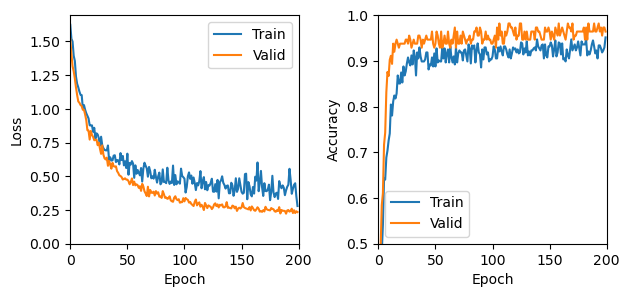

In [18]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 2)
axes[0].plot(metrics["train_loss"], label="Train")
axes[0].plot(metrics["valid_loss"], label="Valid")


axes[1].plot(metrics["train_acc"], label="Train")
axes[1].plot(metrics["valid_acc"], label="Valid")

axes[0].set_ylim(bottom=0.0)
axes[1].set_ylim(bottom=0.5, top=1.0)

axes[0].set_ylabel("Loss")
axes[1].set_ylabel("Accuracy")


for axis in axes.ravel():
    axis.set_xlabel("Epoch")
    axis.set_xlim(left=0.0, right=len(metrics["train_acc"]))
    axis.set_aspect(
        (axis.get_xlim()[1] - axis.get_xlim()[0])
        / (axis.get_ylim()[1] - axis.get_ylim()[0])
    )
    axis.legend()


figure.tight_layout()

plt.show()

With no prior knowledge of this dataset, this seems a reasonable start.